In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load preds

In [14]:
import json

RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_coherence_icl20_20240810135720/outputs_val.json"
METRICS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_coherence_icl20_20240810135720/metrics_coherence_vlm_val.json"
preds = json.load(open(RESULTS_PATH, "r"))
coherence_metrics = json.load(open(METRICS_PATH, "r"))

# Look at cases with low relevance high informativeness

In [18]:
low_rel_low_info = []
low_rel_high_info = []
high_rel_low_info = []
high_rel_high_info = []

for output in preds.values():
    for question_idx in range(output['final_turn'] + 1):
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]
        selected_candidate_idx = output['candidate_questions'][question_idx].index(question)
        relevance = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['informativeness_marginal']
        
        if relevance <= 0.2 and informativeness <= 0.2:
            low_rel_low_info.append((output['procedure'], question, answer))
        elif relevance <= 0.2 and informativeness >= 0.9:
            low_rel_high_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness <= 0.2:
            high_rel_low_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness >= 0.9:
            high_rel_high_info.append((output['procedure'], question, answer))
        
    

In [19]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in low_rel_high_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

Sew the shoe with the thread and the awl in your hands -> Is the shoe in the process of being sewn? Yes
Insert the awl into the sandal -> Is the person holding the awl? Yes
Pull the thread -> Is the person holding the thread? Yes
Pull the thread -> Is the person's hand holding the thread? Yes
Clean the clay box with sand -> Is the person working on the procedure "Clean the clay box with sand"? Yes
Pick brush -> Is the person's hand holding the brush? Yes
Drop the towel on the chair -> Is the towel on the floor? No
Close the pack of sauce -> Is the pack of sauce sitting on the table? Yes
Cut a leaf with a scissor -> Are the scissors open or closed? Yes
Place the wood piece on a wall -> Is the person holding the wood piece? Yes
Remove the piece of wood from the wood cutting machine -> Is the piece of wood on the ground? Yes
Drop the bucket on the table -> Is the bucket on the ground? No
Remove the cut piece of wood from the cutting machine -> Is there a cutting machine in the image? Yes


In [14]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in high_rel_low_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

In [24]:
from scipy.stats import entropy

print(entropy([0.5, 0.5], [0.4, 0.6]))


def relative_entropy(binary_prob0, binary_prob1):
    p0a = binary_prob0
    p0b = 1.0 - binary_prob0
    
    p1a = binary_prob1
    p1b = 1.0 - binary_prob1
    
    ent = np.log2(p0a/p1a)

0.020410997260127586


# Look at how max number of iterations impacts accuracy

In [36]:
from collections import defaultdict
import numpy as np

n_turns = []
success_probs_by_turn = defaultdict(list)
for output in preds.values():
    n_turns.append(output['final_turn'] + 1)
    for question_idx in range(10):
        this_question_idx = min(output['final_turn'], question_idx)
        
        question = output['questions'][this_question_idx]
        answer = output['answers'][this_question_idx]
        selected_candidate_idx = output['candidate_questions'][this_question_idx].index(question)
        relevance = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['informativeness_marginal']
        
        success_prob = output['success_probs'][this_question_idx]
        success_probs_by_turn[question_idx].append(success_prob)
        
print("Average number of turns:", np.mean(n_turns))
print("Number of probs per turn:", [len(success_probs_by_turn[question_idx]) for question_idx in success_probs_by_turn])


Average number of turns: 3.828
Number of probs per turn: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [37]:
from pprint import pprint

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS
from travel.model.metrics import mistake_detection_metrics

all_labels_binary = [output['mistake'] for output in preds.values()]

accuracy_metrics_by_question_idx = []
for question_idx in success_probs_by_turn:
    all_probs = success_probs_by_turn[question_idx]
    
    # Calculate accuracy metrics
    best_metrics = None
    best_threshold = None
    accuracy_metrics_by_threshold = {}
    coherence_metrics_by_threshold = {}
    for threshold in MISTAKE_DETECTION_THRESHOLDS:
        threshold_preds = [1.0 - p >= threshold for p in all_probs] # Have to do 1.0 - probability since we got "success" probability from VLM
        assert len(threshold_preds) == len(all_probs) == len(all_labels), "Expected same number of preds, probs, and labels."
        this_metrics = mistake_detection_metrics(all_labels_binary, threshold_preds)
        accuracy_metrics_by_threshold[threshold] = this_metrics

        if best_metrics is None or (this_metrics['false_positive_rate'] + this_metrics['false_negative_rate']) < (best_metrics['false_positive_rate'] + best_metrics['false_negative_rate']):
            best_metrics = this_metrics
            best_threshold = threshold

    accuracy_metrics_by_threshold['best_metrics'] = best_metrics
    accuracy_metrics_by_threshold['best_threshold'] = best_threshold
    
    accuracy_metrics_by_question_idx.append(accuracy_metrics_by_threshold)


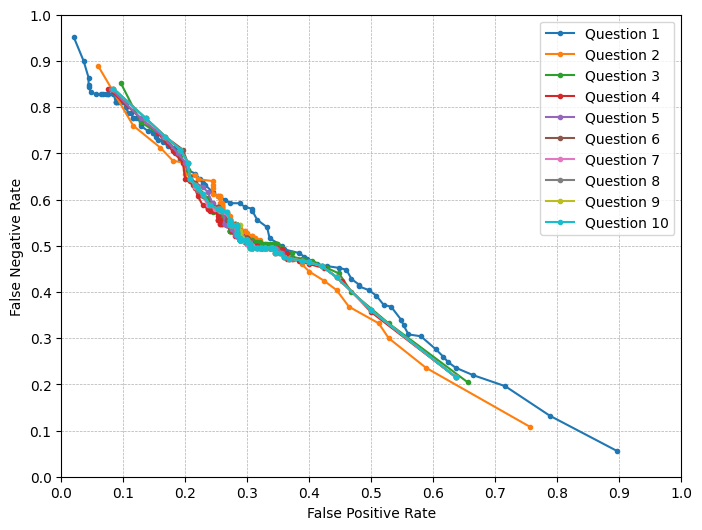

In [38]:
from travel.model.metrics import generate_det_curves

generate_det_curves(accuracy_metrics_by_question_idx, curve_names=[f"Question {question_idx+1}" for question_idx in range(len(accuracy_metrics_by_question_idx))], save_paths=[])